In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections.abc import Callable

import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import torch
from tqdm import tqdm
from transformer_lens import HookedTransformer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

from teren.config import ExperimentConfig, Reference
from teren.perturbations import (
    NaiveRandomPerturbation,
    RandomPerturbation,
    RandomActivationPerturbation,
    SAEDecoderDirectionPerturbation,
    run_perturbation
)
from teren.utils import (
    generate_prompt,
    load_pretokenized_dataset,
    set_seed,
    get_device_str,
    set_seed
)

In [3]:
cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [4]:
set_seed(cfg.seed)

In [5]:
dataset = load_pretokenized_dataset(
    path="apollo-research/Skylion007-openwebtext-tokenizer-gpt2", split="train"
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=cfg.dataloader_batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/73 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [7]:
base_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
base_ref = Reference(
    model,
    base_prompt,
    cfg.perturbation_layer,
    cfg.read_layer,
    cfg.perturbation_pos,
    cfg.n_ctx,
)

In [8]:
print(base_prompt)

tensor([[ 338, 5059,  262, 6672,  287, 2669,   13, 9570, 5865, 3205]])


In [9]:
import random

rng = random.Random(cfg.seed)

In [10]:
rng.randint(0,100)

81

In [11]:
saes, sparsities = get_gpt2_res_jb_saes(cfg.perturbation_layer)
sae = saes[cfg.perturbation_layer].cpu()
sparsity = sparsities[cfg.perturbation_layer].cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.77it/s]


In [13]:
import operator
from teren.perturbations import SAEFeaturePerturbation, TestPerturbation, NaiveRandomPerturbation, SAEActivationPerturbation, SyntheticActivationPerturbation
from teren.utils import get_random_activation

In [56]:
control = defaultdict(list)
bias = defaultdict(list)

for i in range(50):
    random_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    random_ref = Reference(
        model,
        random_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    
    target_o = torch.zeros_like(random_ref.act)
    target_b = sae.b_dec.unsqueeze(0).unsqueeze(0)

    thresh = 0.1
    feature_acts = sae.encode(random_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_act = get_random_activation(
            random_ref.model,
            dataset,
            random_ref.n_ctx,
            random_ref.perturbation_layer,
            random_ref.perturbation_pos,
        )
    
    random_activation_perturbation = RandomActivationPerturbation(random_ref, target_o, dataset)
    control_kl_div = run_perturbation(cfg, random_ref, random_activation_perturbation, reduce=True)
    control[i].append(control_kl_div)

    random_bias_activation_perturbation = RandomActivationPerturbation(random_ref, target_b, dataset)
    bias_kl_div = run_perturbation(cfg, random_ref, random_bias_activation_perturbation, reduce=True)
    bias[i].append(bias_kl_div)

/tmp/ipykernel_4859/2442320468.py:4: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(control[i][0]), color='red', linewidth=0.5)
/tmp/ipykernel_4859/2442320468.py:7: RuntimeWarning: invalid value encountered in log10
  ax[1].plot(np.log10(bias[i][0]), color='green', linewidth=0.5)


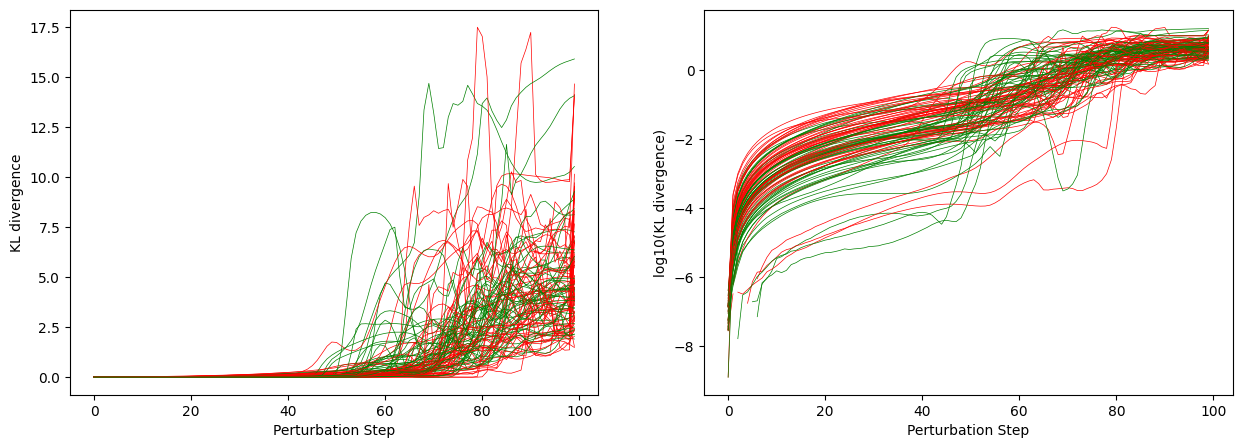

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
for i in range(len(control.keys())):
    ax[0].plot(control[i][0], color='red', linewidth=0.5)
    ax[1].plot(np.log10(control[i][0]), color='red', linewidth=0.5)

    ax[0].plot(bias[i][0], color='green', linewidth=0.5)
    ax[1].plot(np.log10(bias[i][0]), color='green', linewidth=0.5)
    
    ax[0].set_xlabel("Perturbation Step")
    ax[0].set_ylabel("KL divergence")

    ax[1].set_xlabel("Perturbation Step")
    ax[1].set_ylabel("log10(KL divergence)")

fig.show()

In [55]:
# Examining SAE features
def get_results_for_prompt(exp_ref, cfg, sae, n_control, thresh, normalize=False):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    orthogonal_features = {}
    for f_idx in range(sae.W_dec.shape[0]):
        if len(orthogonal_features.keys()) == 20:
            break
        nope = False
        for af_idx in active_features.keys():
            if torch.einsum("... k, ... k -> ... ", sae.W_dec[f_idx], sae.W_dec[af_idx]).abs() > 0.01:
                nope = True
                break 
        if not nope:
            orthogonal_features[f_idx] = feature_acts[f_idx]

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(orthogonal_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    results = defaultdict(defaultdict)
    control = defaultdict(list)
    sae_control = defaultdict(list)

    for i in tqdm(range(n_control)):
        
        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )
        #target = sae.b_dec.unsqueeze(0).unsqueeze(0)

        #target = torch.zeros_like(exp_ref.act)

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=False)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=False)
        sae_control[i].append(sae_kl_div)
    
    for i in tqdm(range(len(sorted_features))):  
        saefeat_perturbation = SAEFeaturePerturbation(exp_ref, sorted_features[i], sae, negate=1)
        kl_div = run_perturbation(cfg, exp_ref, saefeat_perturbation, reduce=False)
        results[sorted_features[i][0]]['kl_div'] = kl_div

    #print(results.keys())
    #print(control.keys())

    assert [i[0] for i in sorted_features] == list(results.keys())

    feature_activation = torch.Tensor([feature[1] for feature in sorted_features])
    #print(feature_activation)

    recon_feature_dir = sae.W_dec[[feature[0] for feature in sorted_features]]
    feature_dot_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, exp_ref.act)  / torch.norm(exp_ref.act)
    #print(feature_act_dot)
    feature_dot_bias_act = torch.einsum("... k, ... k -> ...", recon_feature_dir, (exp_ref.act - sae.b_dec.unsqueeze(0).unsqueeze(0))) / torch.norm((exp_ref.act - sae.b_dec.unsqueeze(0).unsqueeze(0)))

    feature_sparsity = sparsity[list(results.keys())]
    #print(feature_sparsity)

    feature_dot_feature = []
    for feature in sorted_features:
        feature_dot_all = torch.einsum("...k, ... j k -> ... j", sae.W_dec[feature[0]], sae.W_dec[[feature_idx for feature_idx in active_features.keys() if feature_idx != feature[0]]])
        feature_dot_feature.append(feature_dot_all.min(dim=-1)[0])
    feature_dot_feature = torch.Tensor(feature_dot_feature)
    #print(feature_other)

    feature_cleanness = []
    for feature in sorted_features:
        single_feature_act = torch.zeros_like(feature_acts)
        single_feature_act[feature[0]] = torch.norm(exp_ref.act).item()
        f_act = torch.nn.functional.softmax(single_feature_act, dim=-1)
        recon_f_act = torch.nn.functional.softmax(sae.encode(sae.decode(single_feature_act)), dim=-1)
        feature_cleanness.append(-1 * (recon_f_act - f_act).abs().sum())
    feature_cleanness = torch.Tensor(feature_cleanness)

    if normalize:
        for i, feature in enumerate(sorted_features):
            feature_activation[i] /= (feature_activation.max(dim=-1)[0])
            feature_dot_act[0][i] /= (feature_dot_act[0].max(dim=-1)[0])
            feature_dot_bias_act[0][i] /= (feature_dot_bias_act[0].max(dim=-1)[0])
            feature_sparsity[i] /= (feature_sparsity.abs().max(dim=-1)[0])
            feature_dot_feature[i] /= (feature_dot_feature.max(dim=-1)[0])
            feature_cleanness[i] /= (-1 * feature_cleanness.min(dim=-1)[0])

    for i, feature in enumerate(sorted_features):
        results[feature[0]]['Feature Activation'] = feature_activation[i]
        results[feature[0]]['Feature Dot Act'] = feature_dot_act[0][i]
        results[feature[0]]['Feature Dot Bias Act'] = feature_dot_bias_act[0][i]
        results[feature[0]]['Feature Sparsity'] = feature_sparsity[i]
        results[feature[0]]['Feature Dot Feature'] = feature_dot_feature[i]
        results[feature[0]]['Feature Cleanness'] = feature_cleanness[i]


    properties = {"Feature Activation": [feature_activation.min(dim=-1)[0].item(), feature_activation.max(dim=-1)[0].item()], 
                  "Feature Dot Act": [feature_dot_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_act.squeeze(0).max(dim=-1)[0].item()],
                  "Feature Dot Bias Act": [feature_dot_bias_act.squeeze(0).min(dim=-1)[0].item(), feature_dot_bias_act.squeeze(0).max(dim=-1)[0].item()], 
                  "Feature Sparsity": [feature_sparsity.min(dim=-1)[0].item(), feature_sparsity.max(dim=-1)[0].item()], 
                  "Feature Dot Feature": [feature_dot_feature.min(dim=-1)[0].item(), feature_dot_feature.max(dim=-1)[0].item()],
                  "Feature Cleanness": [feature_cleanness.min(dim=-1)[0].item(), feature_cleanness.max(dim=-1)[0].item()]}

    return results, control, sae_control, properties


In [39]:
def plot_all_results(fig, ax, results, control, sae_control, properties):
    colors = plt.cm.viridis(np.linspace(0,1,len(results.keys())))

    for i, color_property in enumerate(properties.keys()):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            #ax[i][2].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")

        plot_order = sorted(results.items(), key = lambda item: item[1][color_property])

        for j, (feature_idx, data) in enumerate(plot_order):
            kl_div = data['kl_div']
            ax[i][0].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][1].plot(kl_div, color=colors[j], linewidth=0.5)
            ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)

        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        ax[i][0].set_xlim(0,100)
        #ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        ax[i][1].set_xlim(0,100)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {cfg.read_layer}")
        ax[i][2].set_ylabel("KL divergence to base logits")
        #ax[i][2].set_xlim(0,75)
        #ax[i][2].set_ylim(-0.01,2)

        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=properties[color_property][0], vmax=properties[color_property][1]))
        cbar = fig.colorbar(sm, ax=ax[i][2])
        cbar.set_label(color_property)
    

In [40]:
our_prompt = "The capital of France is Paris"
our_tokens = torch.tensor([model.tokenizer.encode(our_prompt)])
cfg.n_ctx = our_tokens.shape[1]

In [41]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 2
    results, controls, sae_controls, properties = get_results_for_prompt(exp_ref, cfg, sae, n_control=n_control, thresh = 0.1, normalize=False)

    if i == 0:
        all_results = results
        all_properties = properties                                     
        all_controls = controls
        all_sae_controls = sae_controls
    else:
        for f_idx, result in results.items():
            all_results[f_idx] = result 
        
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control

        for property in properties.keys():
            all_properties[property][0] = min(properties[property][0], all_properties[property][0])
            all_properties[property][1] = max(properties[property][1], all_properties[property][1])
    print(all_properties)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[ 250, 3792,  262, 6994, 5342, 4684]])
Prompt: �Is the prime minister willing
2152
12757
Using 2 active features: {17507: tensor(32.5637), 24149: tensor(9.4219)}


Base Recon Error: 186.64442443847656
Target Recon Error: 184.24989318847656


Base Recon Error: 186.64442443847656
Target Recon Error: 178.5136260986328


100%|██████████| 1/1 [00:06<00:00,  6.67s/it]

{'Feature Activation': [0.0, 0.0], 'Feature Dot Act': [-0.05136317014694214, 0.04421725496649742], 'Feature Dot Bias Act': [-0.018288040533661842, 0.018159685656428337], 'Feature Sparsity': [-10.0, -2.181253671646118], 'Feature Dot Feature': [-0.008948801085352898, 0.00700698047876358], 'Feature Cleanness': [-2.000016212463379, -8.218045570383827e-23]}


In [42]:
# interesting prompts
#tensor([[13566,  5985, 46380, 32680,   373,  4248]])
#Prompt:  Diamond Clean Toothbrush was £



/tmp/ipykernel_3454/4281244251.py:19: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(kl_div), color=colors[j], linewidth=0.5)


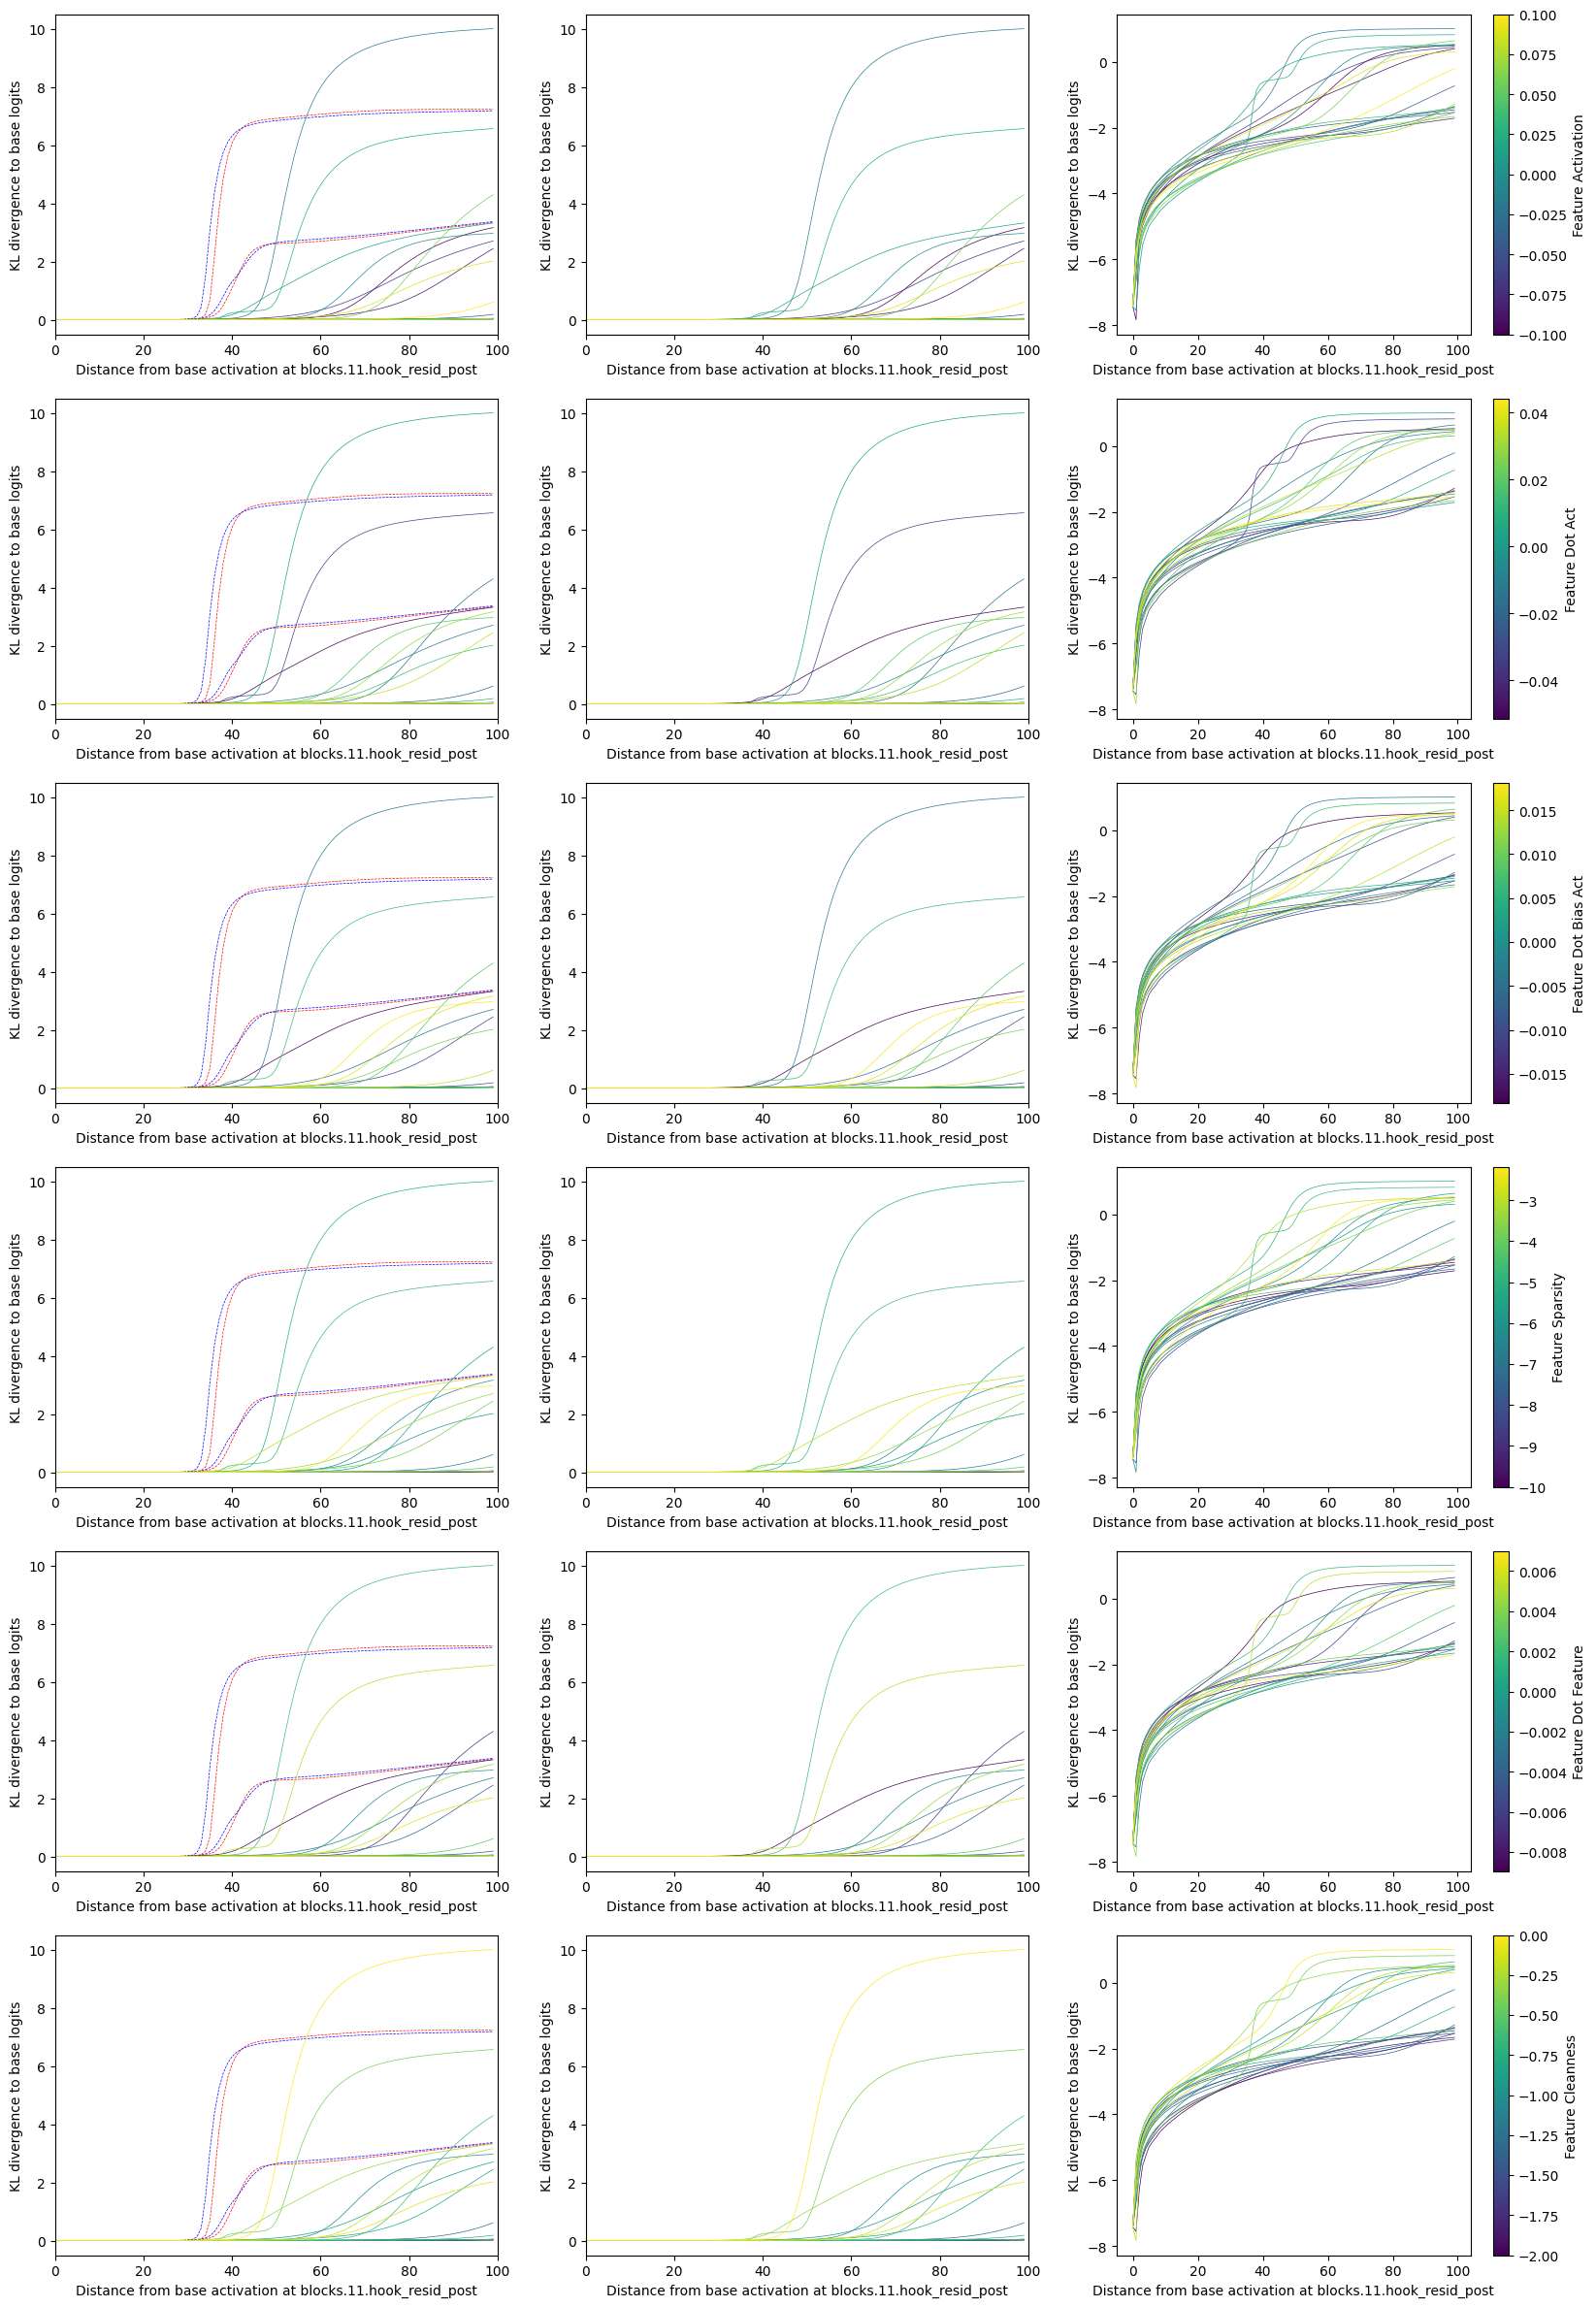

In [43]:
fig, ax = plt.subplots(len(properties.keys()), 3, figsize=(20,5*len(properties.keys())))

plot_all_results(fig, ax, all_results, all_controls, all_sae_controls, all_properties)
fig.show()

In [13]:
syn_cfg = ExperimentConfig(
    n_ctx=10,
    perturbation_layer="blocks.1.hook_resid_pre",
    seed=42,
    dataloader_batch_size=15,
    perturbation_pos=slice(-1, None, 1),
    read_layer="blocks.11.hook_resid_post",
    perturbation_range=(0.0, 1.0),
    n_steps=100,
    mean_batch_size=700,
)

In [31]:
# Examining SAE features
def get_syn_results_for_prompt(exp_ref, cfg, sae, n_control, n_syn, thresh, reduce=True):

    feature_acts = sae.encode(exp_ref.cache[sae.cfg.hook_name])[0, -1, :]
    active_features = {feature_idx: feature_acts[feature_idx] for feature_idx in range(feature_acts.shape[0]) if feature_acts[feature_idx] / feature_acts.max() > thresh}

    random_features = {feature_idx: feature_acts[feature_idx] for feature_idx in random.sample(range(feature_acts.shape[0]), 20) if feature_acts[feature_idx] == 0}

    antiparallel_features = {}
    for feature_idx in active_features.keys():
        active_dot_all = torch.einsum("... k, ... j k -> ... j", sae.W_dec[feature_idx], sae.W_dec[[feature for feature in range(sae.W_dec.shape[0]) if feature != feature_idx]]) 
        min_dot = active_dot_all.min(dim=-1)[1].item()
        if min_dot >= feature_idx:
            antiparallel_features[min_dot+1] = feature_acts[min_dot+1]
            print(min_dot+1)
        else:
            antiparallel_features[min_dot] = feature_acts[min_dot]
            print(min_dot)

    sorted_features = sorted(antiparallel_features.items(), key=operator.itemgetter(1))
    sorted_features2 = sorted(random_features.items(), key=operator.itemgetter(1))

    print(f"Using {len(active_features.keys())} active features: {active_features}")

    control = defaultdict(list)
    sae_control = defaultdict(list)
    for i in tqdm(range(n_control)):

        target = get_random_activation(
            exp_ref.model,
            dataset,
            exp_ref.n_ctx,
            exp_ref.perturbation_layer,
            exp_ref.perturbation_pos,
        )

        random_activation_perturbation = RandomActivationPerturbation(exp_ref, target, dataset)
        control_kl_div = run_perturbation(cfg, exp_ref, random_activation_perturbation, reduce=reduce)
        control[i].append(control_kl_div)

        sae_activation_perturbation = SAEActivationPerturbation(exp_ref, target, dataset, sae)
        sae_kl_div = run_perturbation(cfg, exp_ref, sae_activation_perturbation, reduce=reduce)
        sae_control[i].append(sae_kl_div)

    syn = defaultdict(list)
    syn_add = defaultdict(list)
    for i in tqdm(range(n_syn)):

        target_f_idxs = random.sample(
            [
                f_idx
                for f_idx in range(sae.W_dec.shape[0])
                if f_idx not in active_features.keys()
            ],
            len(active_features.keys()),
        )

        syn_activation_perturbation = SyntheticActivationPerturbation(exp_ref, thresh, dataset, sae, target_f_idxs, additive=False)
        syn_kl_div = run_perturbation(cfg, exp_ref, syn_activation_perturbation, reduce=reduce)
        syn[i].append(syn_kl_div)

        syn_add_activation_perturbation = SyntheticActivationPerturbation(exp_ref, thresh, dataset, sae, target_f_idxs, additive=True)
        syn_add_kl_div = run_perturbation(cfg, exp_ref, syn_add_activation_perturbation, reduce=reduce)
        syn_add[i].append(syn_add_kl_div)

    return control, sae_control, syn, syn_add


In [32]:
def plot_syn_results(fig, ax, control, sae_control, syn, syn_add):

    for i in range(2):
        for control_kl_div in control.values():
            ax[i][0].plot(control_kl_div[0], color='red', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].plot(np.log10(control_kl_div[0]), color='red', label=f"Control", linewidth=0.5, linestyle="--")

        for sae_kl_div in sae_control.values():
            ax[i][0].plot(sae_kl_div[0], color='blue', label=f"Control", linewidth=0.5, linestyle="--")
            ax[i][2].plot(np.log10(sae_kl_div[0]), color='blue', label=f"Control", linewidth=0.5, linestyle="--")

    for syn_kl_div in syn.values():
        ax[0][0].plot(syn_kl_div[0], linewidth=1.0)
        ax[0][1].plot(syn_kl_div[0], linewidth=1.0)
        ax[0][2].plot(np.log10(syn_kl_div[0]), linewidth=1.0)
    
    for syn_add_kl_div in syn_add.values():
        ax[1][0].plot(syn_add_kl_div[0], linewidth=1.0)
        ax[1][1].plot(syn_add_kl_div[0], linewidth=1.0)
        ax[1][2].plot(np.log10(syn_add_kl_div[0]), linewidth=1.0)

    for i in range(2):
        #ax.legend(fontsize=8)
        ax[i][0].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][0].set_ylabel("KL divergence to base logits")
        #ax[i][0].set_xlim(0, 361)
        #ax[i][0].set_ylim(-0.1, 20)

        ax[i][1].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][1].set_ylabel("KL divergence to base logits")
        #ax[i][1].set_xlim(0, 361)
        #ax[i][1].set_ylim(-0.1, 20)

        ax[i][2].set_xlabel(f"Distance from base activation at {syn_cfg.read_layer}")
        ax[i][2].set_ylabel("log10(KL divergence) to base logits")
        #ax[i][2].set_xlim(0, 180)
        #ax[i][2].set_ylim(-0.01, 2)
    

In [36]:
for i in tqdm(range(1)):
    exp_prompt = generate_prompt(dataset, n_ctx=cfg.n_ctx)
    #exp_prompt = our_tokens
    exp_ref = Reference(
        model,
        exp_prompt,
        cfg.perturbation_layer,
        cfg.read_layer,
        cfg.perturbation_pos,
        cfg.n_ctx,
    )
    print(exp_prompt)
    print(f"Prompt: {model.tokenizer.decode(exp_prompt[0])}")
    n_control = 10
    n_syn = 10
    controls, sae_controls, syns, syn_adds = get_syn_results_for_prompt(exp_ref, syn_cfg, sae, n_control=n_control, n_syn=n_syn, thresh = 0.05, reduce=True)

    if i == 0:                                    
        all_controls = controls
        all_sae_controls = sae_controls
        all_syns = syns
        all_syn_adds = syn_adds
    else:
        for control_idx, control in controls.items():
            all_controls[n_control*i+control_idx] = control
        
        for control_idx, sae_control in sae_controls.items():
            all_sae_controls[n_control*i+control_idx] = sae_control
        
        for control_idx, syn in syns.items():
            all_syns[n_control*i+control_idx] = syn

        for control_idx, syn_add in syn_adds.items():
            all_syn_adds[n_control*i+control_idx] = syn_add

  0%|          | 0/1 [00:00<?, ?it/s]

tensor([[  588, 43144,   257, 40206,   287,   257,  1660,    11, 40237,   262]])
Prompt:  like dipping a sponge in a water, squeezing the
12757
12757
3306
22864
Using 4 active features: {6051: tensor(22.8570), 6429: tensor(1.4373), 11114: tensor(2.5352), 17359: tensor(2.3102)}


Base Recon Error: 136.30386352539062
Target Recon Error: 120.72834014892578


Base Recon Error: 136.30386352539062
Target Recon Error: 130.41131591796875


Base Recon Error: 136.30386352539062
Target Recon Error: 145.00424194335938


Base Recon Error: 136.30386352539062
Target Recon Error: 130.5498046875


Base Recon Error: 136.30386352539062
Target Recon Error: 158.6783447265625


Base Recon Error: 136.30386352539062
Target Recon Error: 944.0040283203125


Base Recon Error: 136.30386352539062
Target Recon Error: 122.3315200805664


Base Recon Error: 136.30386352539062
Target Recon Error: 339.51348876953125


Base Recon Error: 136.30386352539062
Target Recon Error: 128.77906799316406


Base Recon Error: 136.30386352539062
Target Recon Error: 126.19425964355469


100%|██████████| 1/1 [00:31<00:00, 31.03s/it]


In [37]:
print(len(all_syns[0][0]))
print(len(all_controls[0][0]))

100
100


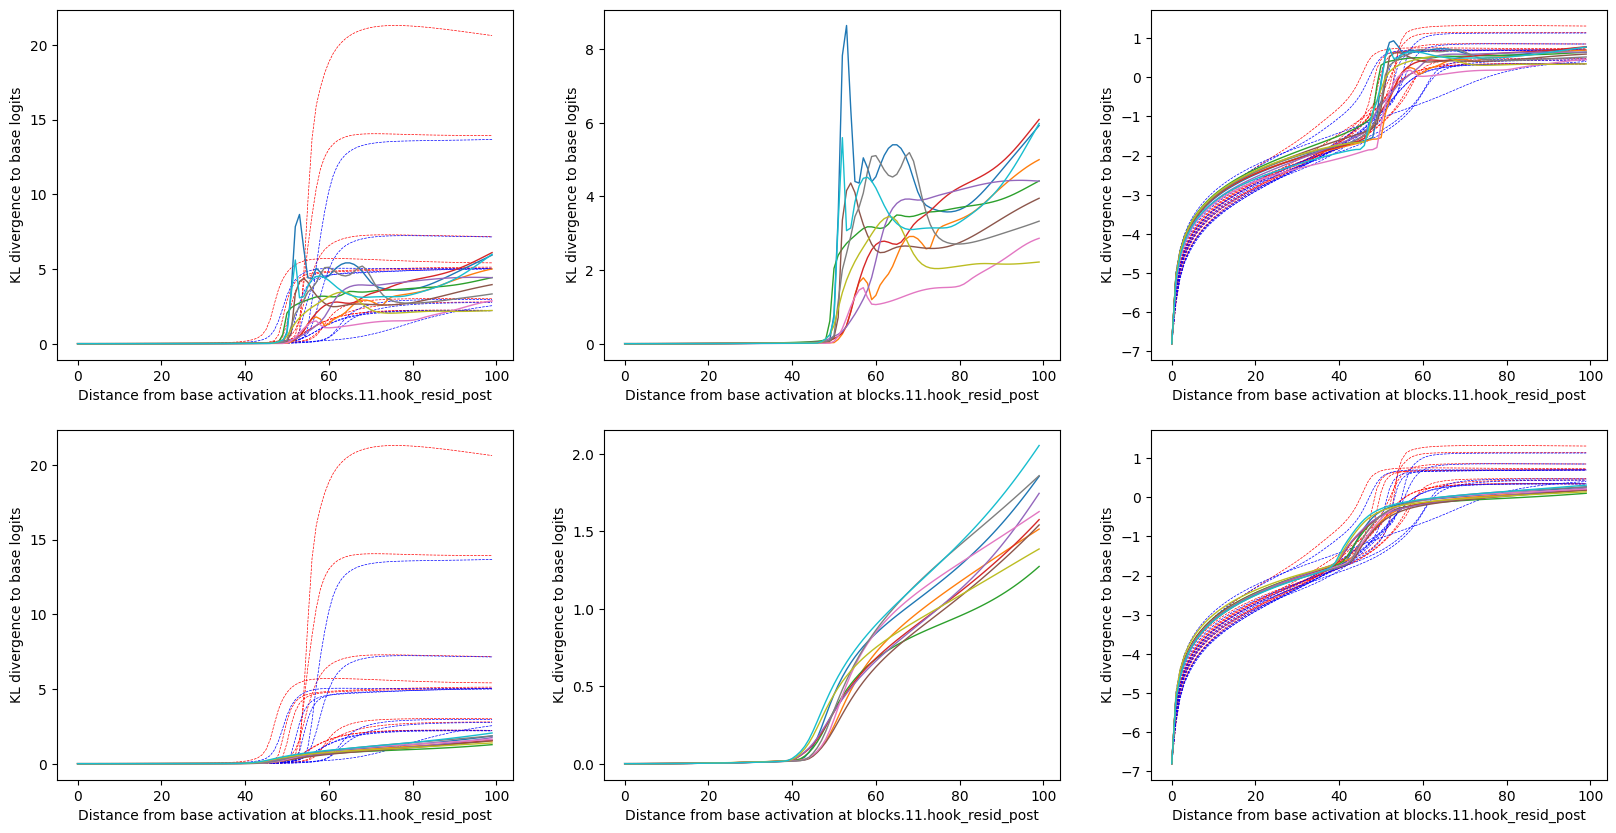

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds)
fig.show()

/tmp/ipykernel_10781/1406675588.py:6: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(control_kl_div[0]), color='red', label=f"Control", linewidth=0.5, linestyle="--")
/tmp/ipykernel_10781/1406675588.py:10: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(sae_kl_div[0]), color='blue', label=f"Control", linewidth=0.5, linestyle="--")
/tmp/ipykernel_10781/1406675588.py:15: RuntimeWarning: invalid value encountered in log10
  ax[0][2].plot(np.log10(syn_kl_div[0]), linewidth=1.0)
/tmp/ipykernel_10781/1406675588.py:20: RuntimeWarning: invalid value encountered in log10
  ax[1][2].plot(np.log10(syn_add_kl_div[0]), linewidth=1.0)


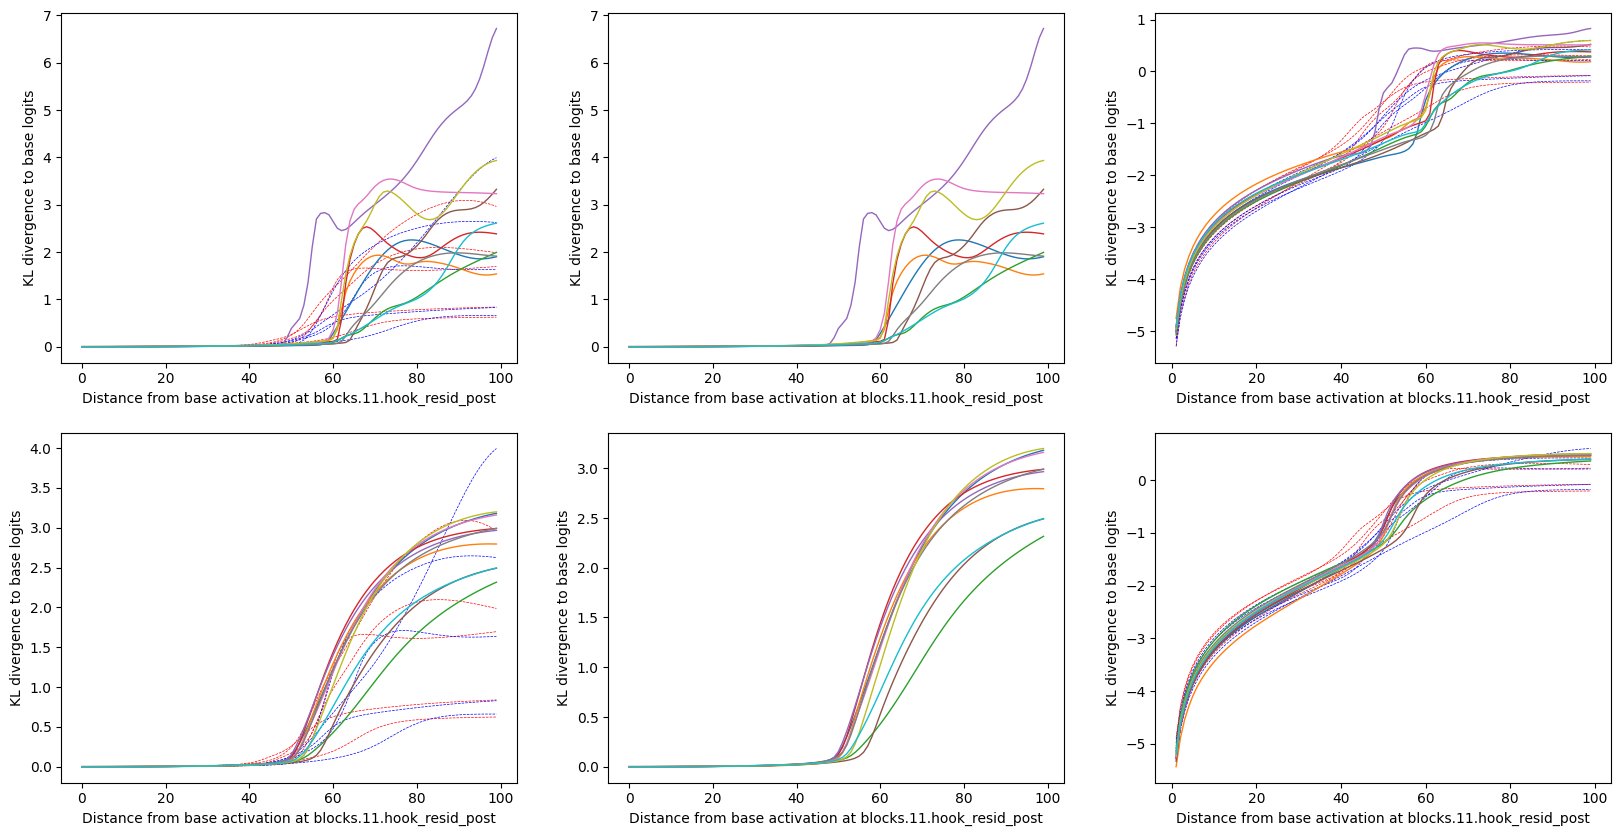

In [35]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds)
fig.show()

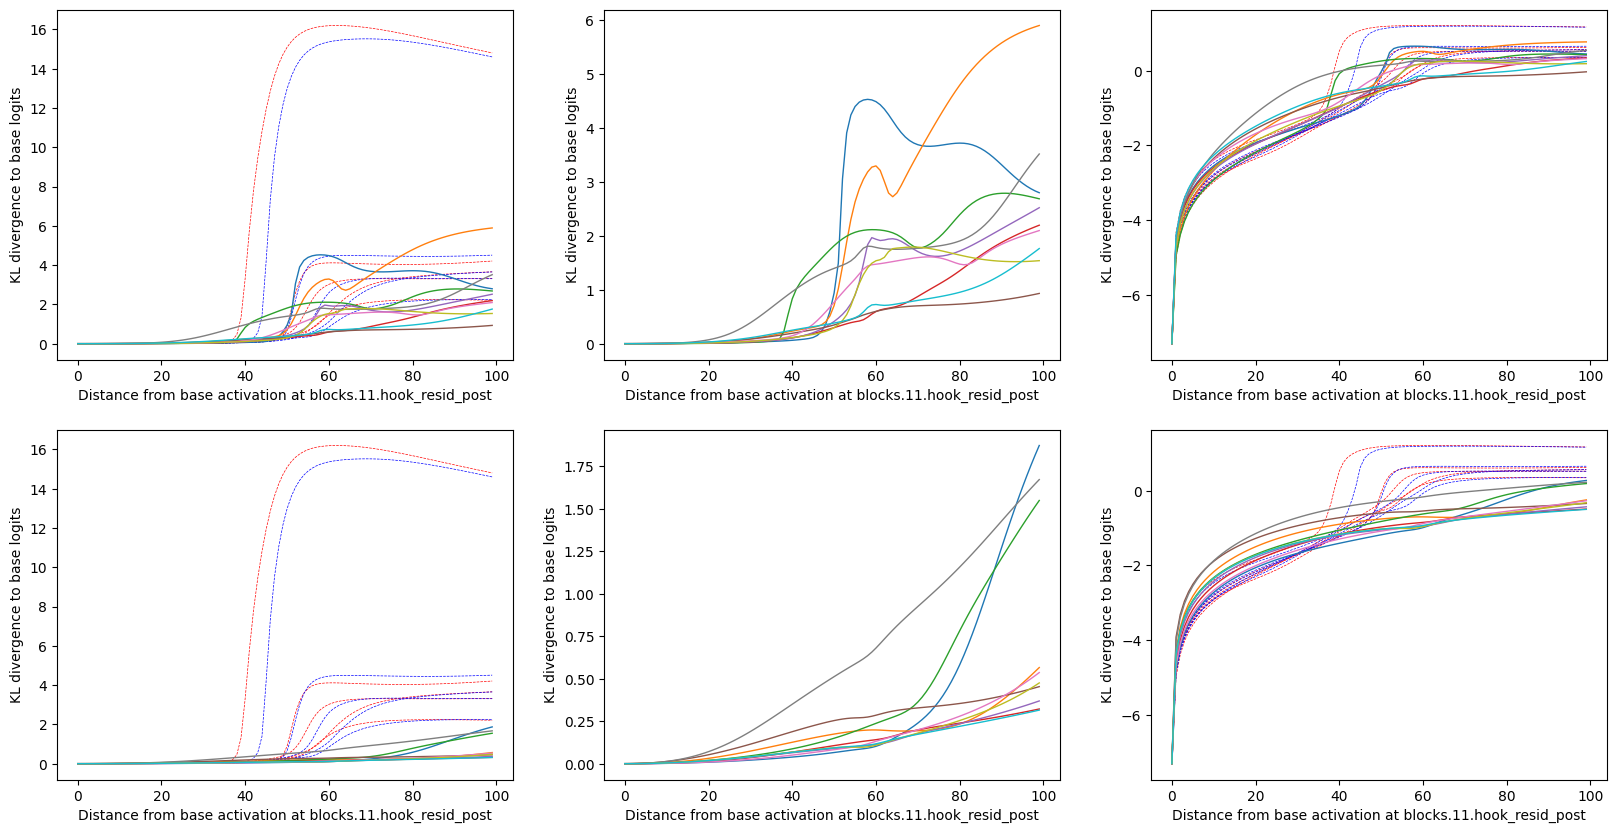

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds)
fig.show()

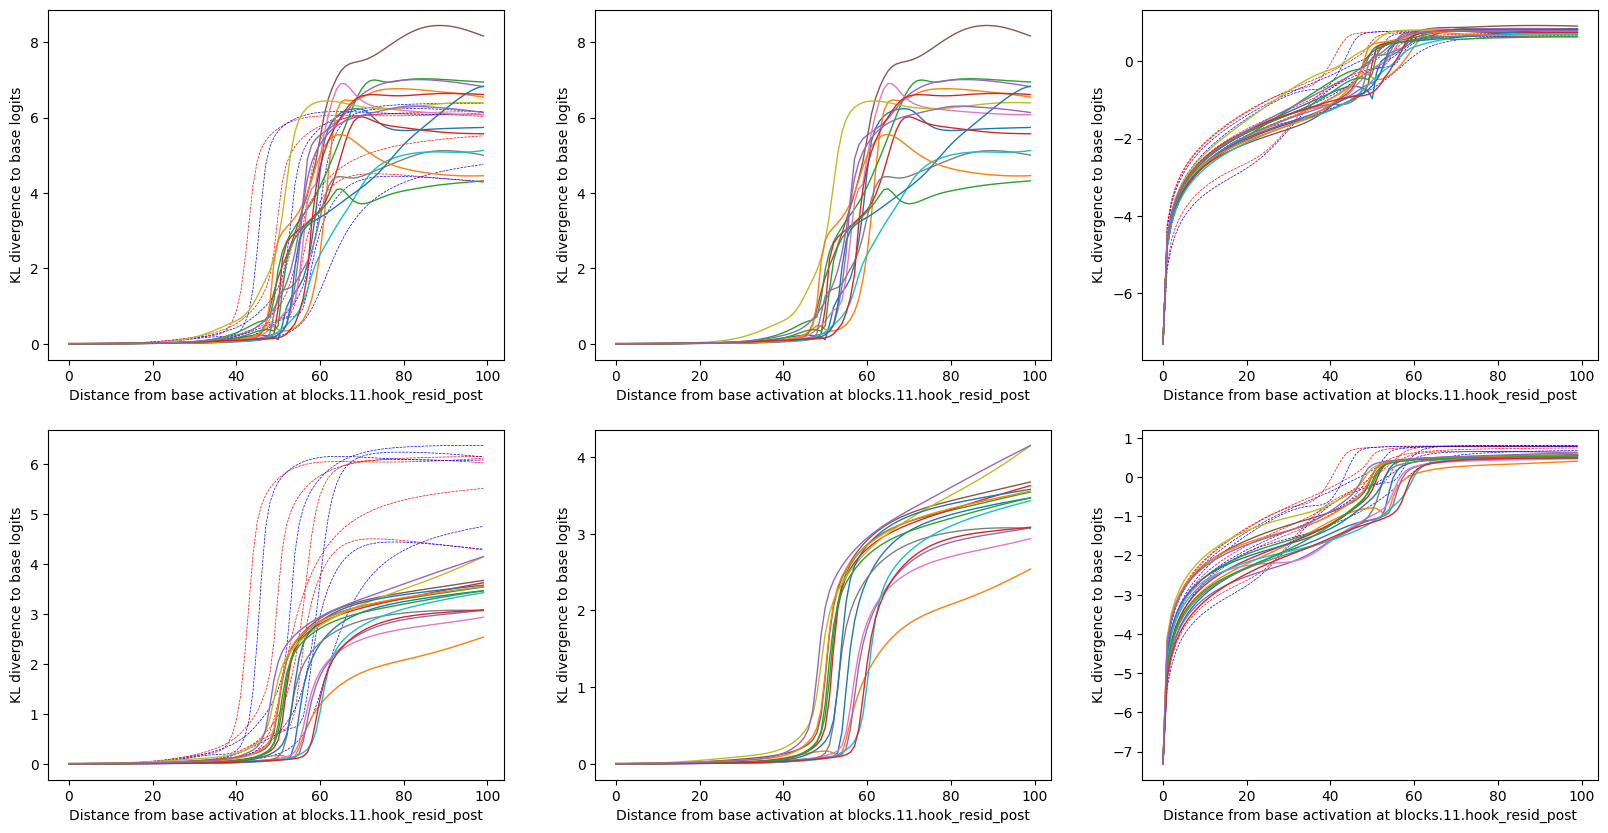

In [25]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds)
fig.show()

/tmp/ipykernel_10500/3936867745.py:6: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(control_kl_div[0]), color='red', label=f"Control", linewidth=0.5, linestyle="--")
/tmp/ipykernel_10500/3936867745.py:10: RuntimeWarning: invalid value encountered in log10
  ax[i][2].plot(np.log10(sae_kl_div[0]), color='blue', label=f"Control", linewidth=0.5, linestyle="--")
/tmp/ipykernel_10500/3936867745.py:15: RuntimeWarning: invalid value encountered in log10
  ax[0][2].plot(np.log10(syn_kl_div[0]), color='green', linewidth=0.5, linestyle="--")
/tmp/ipykernel_10500/3936867745.py:20: RuntimeWarning: invalid value encountered in log10
  ax[1][2].plot(np.log10(syn_add_kl_div[0]), color='green', linewidth=0.5, linestyle="--")


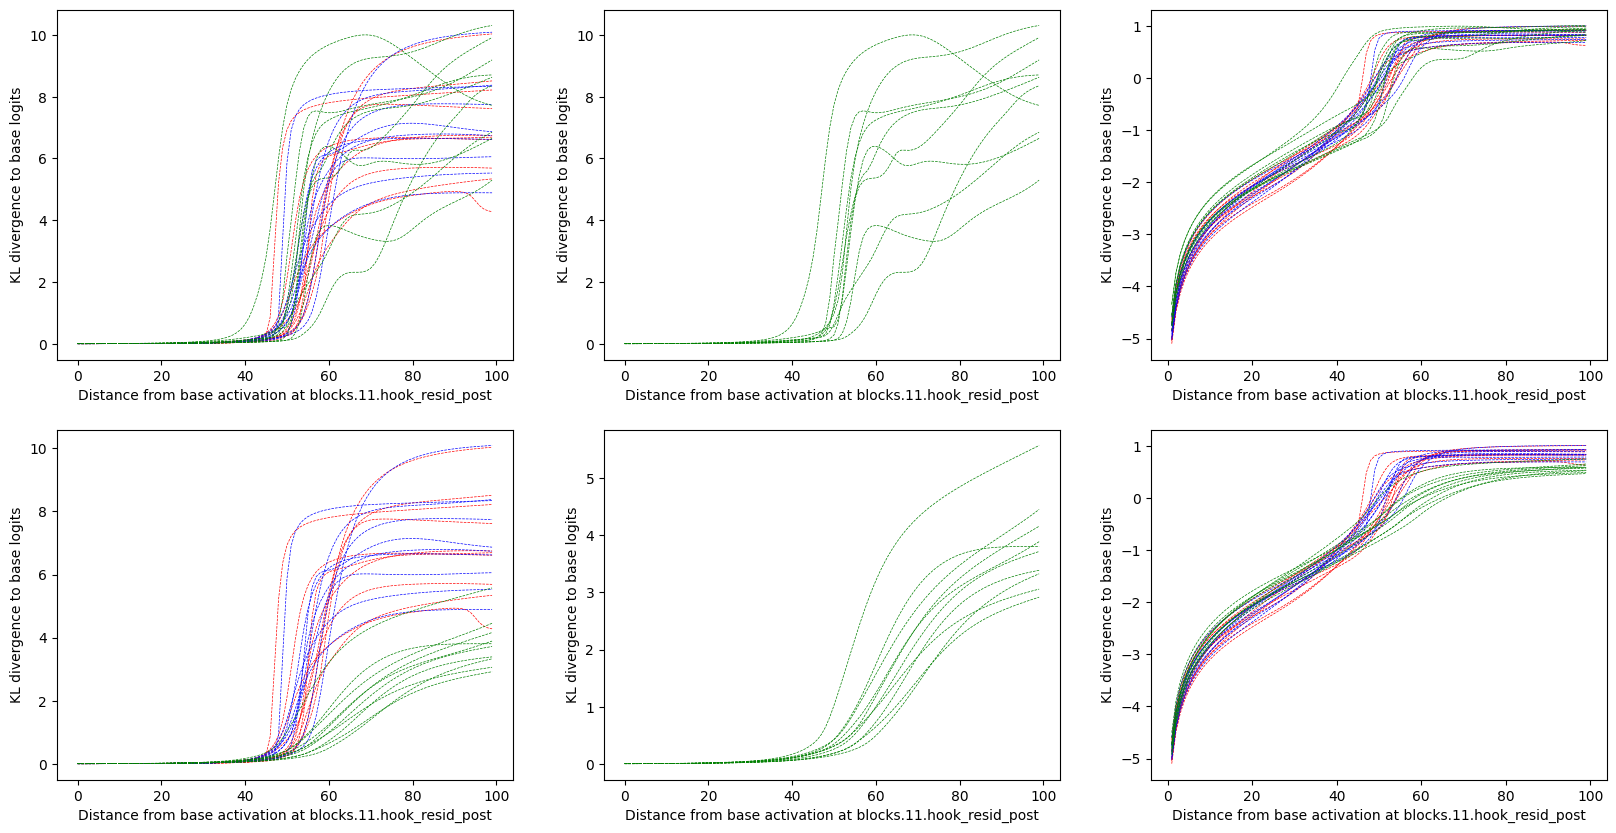

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(20,10))

plot_syn_results(fig, ax, all_controls, all_sae_controls, all_syns, all_syn_adds)
fig.show()

In [ ]:
for i in range(n_control):
    plt.plot(all_controls[i][0], color='red', linestyle='--', linewidth=0.5)
    plt.plot(all_sae_controls[i][0], color='blue', linestyle='--', linewidth=0.5)
    plt.plot(all_syns[i][0], color='green', linestyle='--', linewidth=0.5)
plt.xlabel("Perturbation steps (from base activation to target activation)")
plt.ylabel("KL divergence to base logits")
plt.show()